In [1]:
import sys
sys.path.insert(0, "/home/kohei3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/")
import os
import random

import numpy as np
import pandas as pd
import feather
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)

import matplotlib.pyplot as plt
import tensorflow as tf
import math
import gc
import copy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8986161502963420462
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7896396596
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15074122847688718939
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
train = pd.read_csv("../data/input/train.csv")
test = pd.read_csv("../data/input/test.csv")
target = train["scalar_coupling_constant"].values

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
features = [
        "Atom",
        #"AtomPosition",
        #"AtomDistance",
        #"CouplingType",
        #"AtomEnvironment",
        #"AtomNeighbors",
        #"BruteForce",
        #"DistanceFromClosest",
        #"ElectroNegFromClosest",
        #"ACSF",
        #"MullikenChargePred",
        #"OpenBabelBasic",
        #"CosineDistance",
        #"PotentialPred", 
        "DisIsAllYouNeed"]

In [8]:
X_train = pd.concat([feather.read_dataframe("../features/" + feature + "_train.feather") for feature in features], axis=1)
X_test = pd.concat([feather.read_dataframe("../features/" + feature + "_test.feather") for feature in features], axis=1)

In [9]:
X_train.shape, X_test.shape

((4658147, 40), (2505542, 40))

In [10]:
X_train.head()

,atom_0,atom_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,...,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,H,C,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H,H,6,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H,H,6,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H,H,6,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,C,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# keep nan as is
#coupling_types = X_train['type']
categorical_cols = list(X_train.columns[X_train.dtypes == object])


for col in categorical_cols:    
    print(f'Starting {col}')
    uniques = list(X_train[col].unique())
    if None in uniques:
        uniques.remove(None)
    mapping = dict(zip(uniques, range(1, len(uniques)+1)))
    X_train[col] = X_train[col].map(mapping)
    X_test[col] = X_test[col].map(mapping)

Starting atom_0
Starting atom_1


In [12]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 639.70 MB
Memory usage after optimization is: 577.51 MB
Decreased by 9.7%
Memory usage of dataframe is 344.08 MB
Memory usage after optimization is: 310.63 MB
Decreased by 9.7%


In [13]:
X_train.columns.values

array(['atom_0', 'atom_1', 'atom_2', 'atom_3', 'atom_4', 'atom_5',
       'atom_6', 'atom_7', 'atom_8', 'atom_9', 'd_1_0', 'd_2_0', 'd_2_1',
       'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2',
       'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'], dtype=object)

In [14]:
# Set up GPU preferences
#config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 1} ) 
#config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.6
#sess = tf.Session(config=config) 
#K.set_session(sess)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.33

K.clear_session()
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [15]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(1024, activation="relu")(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
    model = Model(inputs=inp, outputs=[out])
    return model

def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [16]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

mol_types=train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 2000
verbose = 1
batch_size = 1024
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True

start_time=datetime.now()
test_prediction=np.zeros(len(test))

#del train, test
#gc.collect()

cols = list(X_train.columns.values)

oh_cols = ['atom_0', 'atom_1', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 
           'atom_6', 'atom_7', 'atom_8','atom_9']
           #'tertiary_atom_0', 'tertiary_atom_1', 'tertiary_atom_2', 'tertiary_atom_3',
         # 'tertiary_atom_4', 'tertiary_atom_5', 'tertiary_atom_6', 'tertiary_atom_7',
         # 'tertiary_atom_8', 'tertiary_atom_9', 'bond_atom']

continuous_cols = [col for col in cols if col not in oh_cols]


class FeatureTransformer:
    def transform(self, dataset, ohe_features=[], continuous_features=[]):
        ohe_df = OneHotEncoder().fit_transform(dataset.loc[:, ohe_features]).toarray()
        skews = dataset.loc[:, continuous_features].skew().to_dict()
        for column, skew in skews.items():
            if skew > 1:
                dataset[column] = np.log1p(dataset[column])
        return np.concatenate([StandardScaler().fit_transform(dataset.loc[:, continuous_features]), ohe_df], axis=1)


In [17]:
X_train.replace([np.inf, -np.inf], np.nan)
X_test.replace([np.inf, -np.inf], np.nan)

for col in X_train.columns:
    try:
        X_train[col].fillna(0, inplace=True)
    except:
        X_train[col] = X_train[col].cat.add_categories([0])
        X_train[col].fillna(0, inplace=True)
    
for col in X_test.columns:
    try:
        X_test[col].fillna(0, inplace=True)
    except:
        X_test[col] = X_test[col].cat.add_categories([0])
        X_test[col].fillna(0, inplace=True)  

In [18]:
train_type = train['type'].values
test_type = test['type'].values
molecule_name = train['molecule_name'].values

Training 1JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 567440 samples, validate on 141976 samples
Epoch 1/2000
567440/567440 [==============================] - 6s 11us/step - loss: 44.4052 - val_loss: 4.3560
Epoch 2/2000
567440/567440 [==============================] - 5s 10us/step - loss: 2.0254 - val_loss: 1.8921
Epoch 3/2000
567440/567440 [==============================] - 5s 10us/step - loss: 1.8461 - val_loss: 1.6626
Epoch 4/2000
567440/567440 [==============================] - 5s 9us/step - loss: 1.7334 - val_loss: 1.6458
Epoch 5/2000
567440/567440 [==============================] - 5s 10us/step - loss: 1.6905 - val_loss: 1.6284
Epoch 6/2000
567440/567440 [==============================] - 5s 9us/step - loss: 1.6587 - val_loss: 1.5360
Epoch 7/2000
567440/567440 [==============================] - 5s 10us/step - loss: 1.6082 - val_loss: 1.5464
Epoch 8/2000
567440/567440 [==============================] - 5s 10us/step - loss: 1.5889 - val_loss: 1.4

567440/567440 [==============================] - 5s 10us/step - loss: 0.9615 - val_loss: 0.9308
Epoch 148/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.9484 - val_loss: 0.8883
Epoch 149/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.9255 - val_loss: 0.8582
Epoch 150/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.9405 - val_loss: 0.9871
Epoch 151/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.9442 - val_loss: 0.8731
Epoch 152/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.9556 - val_loss: 0.8666
Epoch 153/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.9409 - val_loss: 0.8997
Epoch 154/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.9444 - val_loss: 0.8907
Epoch 155/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.9445 - val_loss: 0.8721
Epoch 156/2000
5674

567440/567440 [==============================] - 5s 10us/step - loss: 0.8853 - val_loss: 0.8666
Epoch 295/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8799 - val_loss: 0.8165
Epoch 296/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8834 - val_loss: 0.8135
Epoch 297/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.8804 - val_loss: 0.8069
Epoch 298/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8728 - val_loss: 0.8212
Epoch 299/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8738 - val_loss: 0.8122
Epoch 300/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8745 - val_loss: 0.8177
Epoch 301/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8809 - val_loss: 0.8223
Epoch 302/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8670 - val_loss: 0.8049
Epoch 303/2000
567440/5

567440/567440 [==============================] - 5s 9us/step - loss: 0.8440 - val_loss: 0.7885
Epoch 441/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8333 - val_loss: 0.7818
Epoch 442/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.8462 - val_loss: 0.7852

Epoch 00442: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 443/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8356 - val_loss: 0.7823
Epoch 444/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8447 - val_loss: 0.7782
Epoch 445/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8360 - val_loss: 0.7789
Epoch 446/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8214 - val_loss: 0.7821
Epoch 447/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8371 - val_loss: 0.7787
Epoch 448/2000
567440/567440 [=======================

567440/567440 [==============================] - 5s 9us/step - loss: 0.8421 - val_loss: 0.7762
Epoch 587/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8432 - val_loss: 0.7755
Epoch 588/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.8230 - val_loss: 0.7755
Epoch 589/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8457 - val_loss: 0.7790
Epoch 590/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8208 - val_loss: 0.7768
Epoch 591/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8211 - val_loss: 0.7770
Epoch 592/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8257 - val_loss: 0.7759
Epoch 593/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8391 - val_loss: 0.7800
Epoch 594/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.8555 - val_loss: 0.7760
Epoch 595/2000
567440/5

Epoch 659/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8348 - val_loss: 0.7763
Epoch 660/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8524 - val_loss: 0.7749
Epoch 661/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8344 - val_loss: 0.7744
Epoch 662/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8256 - val_loss: 0.7763
Epoch 663/2000
567440/567440 [==============================] - 5s 9us/step - loss: 0.8333 - val_loss: 0.7744
Epoch 664/2000
567440/567440 [==============================] - 5s 10us/step - loss: 0.8278 - val_loss: 0.7742
Restoring model weights from the end of the best epoch
Epoch 00664: early stopping


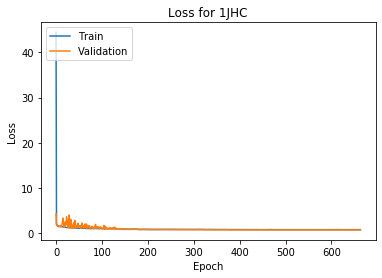

-0.2572463894651664
Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 301863 samples, validate on 76173 samples
Epoch 1/2000
301863/301863 [==============================] - 3s 11us/step - loss: 3.4620 - val_loss: 0.8364
Epoch 2/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.6210 - val_loss: 0.9687
Epoch 3/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.5223 - val_loss: 1.8773
Epoch 4/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.4473 - val_loss: 2.7112
Epoch 5/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.4003 - val_loss: 1.9345
Epoch 6/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.3788 - val_loss: 1.5532
Epoch 7/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.3624 - val_loss: 1.1685
Epoch 8/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.3459 -

301863/301863 [==============================] - 3s 9us/step - loss: 0.1955 - val_loss: 0.2038
Epoch 149/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1995 - val_loss: 0.3556
Epoch 150/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.2035 - val_loss: 0.2131
Epoch 151/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.2024 - val_loss: 0.2092
Epoch 152/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1982 - val_loss: 0.2312
Epoch 153/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.2048 - val_loss: 0.2805
Epoch 154/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1967 - val_loss: 0.3233
Epoch 155/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1994 - val_loss: 0.2232
Epoch 156/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1971 - val_loss: 0.2644
Epoch 157/2000
301863/

301863/301863 [==============================] - 3s 10us/step - loss: 0.1698 - val_loss: 0.1746
Epoch 296/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1730 - val_loss: 0.1528
Epoch 297/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1682 - val_loss: 0.1660
Epoch 298/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1662 - val_loss: 0.1509
Epoch 299/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1700 - val_loss: 0.1628
Epoch 300/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1621 - val_loss: 0.1526
Epoch 301/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1604 - val_loss: 0.1540
Epoch 302/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1692 - val_loss: 0.1541
Epoch 303/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1711 - val_loss: 0.1533
Epoch 304/2000
301863/

301863/301863 [==============================] - 3s 9us/step - loss: 0.1500 - val_loss: 0.1384
Epoch 442/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1512 - val_loss: 0.1362
Epoch 443/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1515 - val_loss: 0.1388
Epoch 444/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1546 - val_loss: 0.1386
Epoch 445/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1490 - val_loss: 0.1367
Epoch 446/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1502 - val_loss: 0.1367
Epoch 447/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1471 - val_loss: 0.1398
Epoch 448/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1492 - val_loss: 0.1372
Epoch 449/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1532 - val_loss: 0.1413
Epoch 450/2000
301863/3

Epoch 514/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1474 - val_loss: 0.1359
Epoch 515/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1439 - val_loss: 0.1356
Epoch 516/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1453 - val_loss: 0.1353
Epoch 517/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1483 - val_loss: 0.1359
Epoch 518/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1450 - val_loss: 0.1359
Epoch 519/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1517 - val_loss: 0.1358
Epoch 520/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1446 - val_loss: 0.1357
Epoch 521/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1537 - val_loss: 0.1356
Epoch 522/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1463 - val_loss: 0.1357
Epoch 5

301863/301863 [==============================] - 3s 9us/step - loss: 0.1511 - val_loss: 0.1358
Epoch 588/2000
301863/301863 [==============================] - 3s 10us/step - loss: 0.1487 - val_loss: 0.1350
Epoch 589/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1496 - val_loss: 0.1352
Epoch 590/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1467 - val_loss: 0.1356
Epoch 591/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1478 - val_loss: 0.1350
Epoch 592/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1450 - val_loss: 0.1356
Epoch 593/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1453 - val_loss: 0.1350
Epoch 594/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1463 - val_loss: 0.1349
Epoch 595/2000
301863/301863 [==============================] - 3s 9us/step - loss: 0.1467 - val_loss: 0.1350
Epoch 596/2000
301863/30

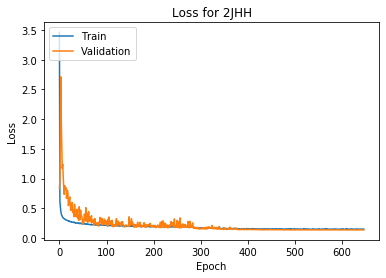

-2.0039402028309588
Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 34764 samples, validate on 8599 samples
Epoch 1/2000
34764/34764 [==============================] - 1s 25us/step - loss: 47.1303 - val_loss: 46.0962
Epoch 2/2000
34764/34764 [==============================] - 0s 10us/step - loss: 45.6382 - val_loss: 43.9385
Epoch 3/2000
34764/34764 [==============================] - 0s 10us/step - loss: 42.8533 - val_loss: 40.3940
Epoch 4/2000
34764/34764 [==============================] - 0s 10us/step - loss: 38.5654 - val_loss: 35.3702
Epoch 5/2000
34764/34764 [==============================] - 0s 10us/step - loss: 32.6934 - val_loss: 17.1606
Epoch 6/2000
34764/34764 [==============================] - 0s 10us/step - loss: 25.2375 - val_loss: 30.3379
Epoch 7/2000
34764/34764 [==============================] - 0s 10us/step - loss: 16.1536 - val_loss: 26.5833
Epoch 8/2000
34764/34764 [==============================] - 0s 10us/step - loss: 6.0670

Epoch 76/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5728 - val_loss: 1.3202

Epoch 00076: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 77/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5438 - val_loss: 1.1362
Epoch 78/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.5349 - val_loss: 1.0382
Epoch 79/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5381 - val_loss: 0.8384
Epoch 80/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5392 - val_loss: 0.8478
Epoch 81/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5303 - val_loss: 0.6566
Epoch 82/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5374 - val_loss: 0.6838
Epoch 83/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5402 - val_loss: 0.7612
Epoch 84/2000
34764/34764 [=============================

Epoch 225/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3894 - val_loss: 0.4720
Epoch 226/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4197 - val_loss: 0.4520
Epoch 227/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4238 - val_loss: 0.4520
Epoch 228/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4690 - val_loss: 0.4915
Epoch 229/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4229 - val_loss: 0.5470
Epoch 230/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4068 - val_loss: 0.4422
Epoch 231/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4431 - val_loss: 0.4423
Epoch 232/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4355 - val_loss: 0.5784
Epoch 233/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4200 - val_loss: 0.4657
Epoch 234/2000
34764/34

Epoch 300/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3803 - val_loss: 0.4247
Epoch 301/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3728 - val_loss: 0.4214
Epoch 302/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4797 - val_loss: 0.4241
Epoch 303/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3994 - val_loss: 0.4631
Epoch 304/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4267 - val_loss: 0.4303
Epoch 305/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3957 - val_loss: 0.4737
Epoch 306/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3842 - val_loss: 0.4427
Epoch 307/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3851 - val_loss: 0.4777
Epoch 308/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3982 - val_loss: 0.4397
Epoch 309/2000
34764/347

34764/34764 [==============================] - 0s 10us/step - loss: 0.4294 - val_loss: 0.4159
Epoch 375/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4223 - val_loss: 0.4172
Epoch 376/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4354 - val_loss: 0.4172
Epoch 377/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4072 - val_loss: 0.4162
Epoch 378/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3870 - val_loss: 0.4186
Epoch 379/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4047 - val_loss: 0.4192
Epoch 380/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3836 - val_loss: 0.4152
Epoch 381/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4013 - val_loss: 0.4494
Epoch 382/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3743 - val_loss: 0.4186
Epoch 383/2000
34764/34764 [=============

Epoch 524/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3914 - val_loss: 0.4140
Epoch 525/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4524 - val_loss: 0.4137
Epoch 526/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3971 - val_loss: 0.4137
Epoch 527/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4030 - val_loss: 0.4146
Epoch 528/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4114 - val_loss: 0.4133
Epoch 529/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3737 - val_loss: 0.4140
Epoch 530/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4130 - val_loss: 0.4149
Epoch 531/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4123 - val_loss: 0.4150
Epoch 532/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4292 - val_loss: 0.4145
Epoch 533/2000
34764/3476

Epoch 673/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3545 - val_loss: 0.4125
Epoch 674/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.4137 - val_loss: 0.4121
Epoch 675/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4015 - val_loss: 0.4119
Epoch 676/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3877 - val_loss: 0.4120
Epoch 677/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4027 - val_loss: 0.4123
Epoch 678/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3645 - val_loss: 0.4122
Epoch 679/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3881 - val_loss: 0.4128
Epoch 680/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.3778 - val_loss: 0.4119
Epoch 681/2000
34764/34764 [==============================] - 0s 9us/step - loss: 0.4315 - val_loss: 0.4123
Epoch 682/2000
34764/3476

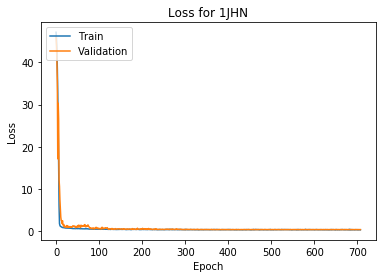

-0.8872641645568449
Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 95787 samples, validate on 23466 samples
Epoch 1/2000
95787/95787 [==============================] - 1s 15us/step - loss: 1.8865 - val_loss: 0.9997
Epoch 2/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.5512 - val_loss: 0.7251
Epoch 3/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.4375 - val_loss: 0.4644
Epoch 4/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.3853 - val_loss: 0.4089
Epoch 5/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.3677 - val_loss: 0.3858
Epoch 6/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.3408 - val_loss: 0.3372
Epoch 7/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.3296 - val_loss: 0.3748
Epoch 8/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.3208 - val_loss: 0.

Epoch 76/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.2004 - val_loss: 0.2102
Epoch 77/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.2049 - val_loss: 0.2067
Epoch 78/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1981 - val_loss: 0.1890
Epoch 79/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1891 - val_loss: 0.1973
Epoch 80/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1939 - val_loss: 0.1952
Epoch 81/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1985 - val_loss: 0.2035
Epoch 82/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.2027 - val_loss: 0.2034
Epoch 83/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1991 - val_loss: 0.1881
Epoch 84/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1975 - val_loss: 0.2181
Epoch 85/2000
95787/95787 [=====

95787/95787 [==============================] - 1s 10us/step - loss: 0.1703 - val_loss: 0.1832
Epoch 227/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1712 - val_loss: 0.1673
Epoch 228/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1667 - val_loss: 0.1724
Epoch 229/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1688 - val_loss: 0.1679
Epoch 230/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1636 - val_loss: 0.1718
Epoch 231/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1761 - val_loss: 0.1763
Epoch 232/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1637 - val_loss: 0.1941
Epoch 233/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1747 - val_loss: 0.1668
Epoch 234/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1589 - val_loss: 0.1712
Epoch 235/2000
95787/95787 [============

Epoch 376/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1380 - val_loss: 0.1568
Epoch 377/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1405 - val_loss: 0.1444
Epoch 378/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1380 - val_loss: 0.1412
Epoch 379/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1345 - val_loss: 0.1444
Epoch 380/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1423 - val_loss: 0.1421
Epoch 381/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1453 - val_loss: 0.1516
Epoch 382/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1575 - val_loss: 0.1624
Epoch 383/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1355 - val_loss: 0.1537
Epoch 384/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1404 - val_loss: 0.1442
Epoch 385/2000
95787/9578

95787/95787 [==============================] - 1s 9us/step - loss: 0.1363 - val_loss: 0.1468
Epoch 527/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1350 - val_loss: 0.1422
Epoch 528/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1397 - val_loss: 0.1451
Epoch 529/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1391 - val_loss: 0.1426
Epoch 530/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1389 - val_loss: 0.1404
Epoch 531/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1350 - val_loss: 0.1433
Epoch 532/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1351 - val_loss: 0.1466
Epoch 533/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1365 - val_loss: 0.1556
Epoch 534/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1352 - val_loss: 0.1416
Epoch 535/2000
95787/95787 [==========

Epoch 675/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1290 - val_loss: 0.1303
Epoch 676/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1212 - val_loss: 0.1293
Epoch 677/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1111 - val_loss: 0.1294
Epoch 678/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1395 - val_loss: 0.1289
Epoch 679/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1188 - val_loss: 0.1294
Epoch 680/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1216 - val_loss: 0.1291
Epoch 681/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1242 - val_loss: 0.1288
Epoch 682/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1199 - val_loss: 0.1286
Epoch 683/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1127 - val_loss: 0.1294
Epoch 684/2000
95787/957

Epoch 750/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1313 - val_loss: 0.1287
Epoch 751/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1238 - val_loss: 0.1283
Epoch 752/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1232 - val_loss: 0.1284
Epoch 753/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1295 - val_loss: 0.1285
Epoch 754/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1229 - val_loss: 0.1285

Epoch 00754: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 755/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1191 - val_loss: 0.1279
Epoch 756/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1249 - val_loss: 0.1281
Epoch 757/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1220 - val_loss: 0.1279
Epoch 758/2000
95787/95787 [=====================

95787/95787 [==============================] - 1s 10us/step - loss: 0.1151 - val_loss: 0.1277
Epoch 825/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1276 - val_loss: 0.1277
Epoch 826/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1220 - val_loss: 0.1277
Epoch 827/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1190 - val_loss: 0.1279
Epoch 828/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1342 - val_loss: 0.1279
Epoch 829/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1208 - val_loss: 0.1277
Epoch 830/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1323 - val_loss: 0.1278
Epoch 831/2000
95787/95787 [==============================] - 1s 9us/step - loss: 0.1215 - val_loss: 0.1277
Epoch 832/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1375 - val_loss: 0.1277
Epoch 833/2000
95787/95787 [===========

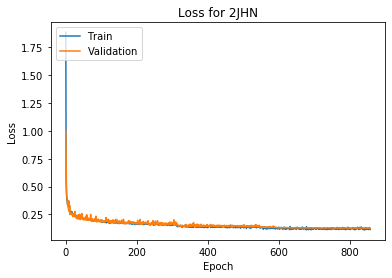

-2.058575705231312
Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 911004 samples, validate on 229670 samples
Epoch 1/2000
911004/911004 [==============================] - 9s 10us/step - loss: 0.8486 - val_loss: 0.6799
Epoch 2/2000
911004/911004 [==============================] - 9s 10us/step - loss: 0.6438 - val_loss: 0.5817
Epoch 3/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.5933 - val_loss: 0.5379
Epoch 4/2000
911004/911004 [==============================] - 8s 9us/step - loss: 0.5628 - val_loss: 0.5238
Epoch 5/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.5368 - val_loss: 0.5015
Epoch 6/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.5193 - val_loss: 0.4818
Epoch 7/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.5057 - val_loss: 0.4788
Epoch 8/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.4942 -

911004/911004 [==============================] - 9s 9us/step - loss: 0.3171 - val_loss: 0.3040
Epoch 149/2000
911004/911004 [==============================] - 9s 10us/step - loss: 0.3138 - val_loss: 0.3051
Epoch 150/2000
911004/911004 [==============================] - 9s 10us/step - loss: 0.3149 - val_loss: 0.3035
Epoch 151/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.3152 - val_loss: 0.3017
Epoch 152/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.3130 - val_loss: 0.3055
Epoch 153/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.3127 - val_loss: 0.3001
Epoch 154/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.3110 - val_loss: 0.3044
Epoch 155/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.3132 - val_loss: 0.3004
Epoch 156/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.3098 - val_loss: 0.3012
Epoch 157/2000
911004/9

Epoch 296/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2813 - val_loss: 0.2746
Epoch 297/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2841 - val_loss: 0.2731
Epoch 298/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2814 - val_loss: 0.2737
Epoch 299/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2811 - val_loss: 0.2750
Epoch 300/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2799 - val_loss: 0.2748
Epoch 301/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2807 - val_loss: 0.2751
Epoch 302/2000
911004/911004 [==============================] - 9s 10us/step - loss: 0.2826 - val_loss: 0.2713
Epoch 303/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2797 - val_loss: 0.2723
Epoch 304/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2804 - val_loss: 0.2740
Epoch 305

Epoch 444/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2692 - val_loss: 0.2634
Epoch 445/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2709 - val_loss: 0.2627
Epoch 446/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2692 - val_loss: 0.2631
Epoch 447/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2705 - val_loss: 0.2628
Epoch 448/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2698 - val_loss: 0.2629
Epoch 449/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2723 - val_loss: 0.2628
Epoch 450/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2691 - val_loss: 0.2641
Epoch 451/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2687 - val_loss: 0.2628
Epoch 452/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2679 - val_loss: 0.2638
Epoch 453/

Epoch 592/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2663 - val_loss: 0.2575
Epoch 593/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2633 - val_loss: 0.2570
Epoch 594/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2657 - val_loss: 0.2576
Epoch 595/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2643 - val_loss: 0.2575
Epoch 596/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2628 - val_loss: 0.2576
Epoch 597/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2637 - val_loss: 0.2570
Epoch 598/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2631 - val_loss: 0.2579
Epoch 599/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2645 - val_loss: 0.2570
Epoch 600/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2622 - val_loss: 0.2580
Epoch 601/

911004/911004 [==============================] - 9s 9us/step - loss: 0.2594 - val_loss: 0.2545
Epoch 740/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2603 - val_loss: 0.2544
Epoch 741/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2610 - val_loss: 0.2543
Epoch 742/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2609 - val_loss: 0.2545
Epoch 743/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2597 - val_loss: 0.2547
Epoch 744/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2610 - val_loss: 0.2546
Epoch 745/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2596 - val_loss: 0.2546
Epoch 746/2000
911004/911004 [==============================] - 9s 10us/step - loss: 0.2613 - val_loss: 0.2543
Epoch 747/2000
911004/911004 [==============================] - 9s 9us/step - loss: 0.2603 - val_loss: 0.2546
Epoch 748/2000
911004/91

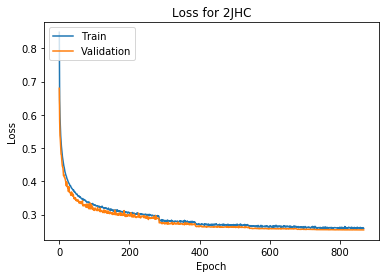

-1.371110119090838
Training 3JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 472508 samples, validate on 118103 samples
Epoch 1/2000
472508/472508 [==============================] - 5s 11us/step - loss: 1.2117 - val_loss: 0.5720
Epoch 2/2000
472508/472508 [==============================] - 5s 10us/step - loss: 0.4758 - val_loss: 0.4682
Epoch 3/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.4294 - val_loss: 0.3844
Epoch 4/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.3979 - val_loss: 0.4094
Epoch 5/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.3843 - val_loss: 0.3678
Epoch 6/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.3662 - val_loss: 0.3472
Epoch 7/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.3526 - val_loss: 0.3358
Epoch 8/2000
472508/472508 [==============================] - 5s 10us/step - loss: 0.3521

472508/472508 [==============================] - 4s 9us/step - loss: 0.2057 - val_loss: 0.1953
Epoch 149/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2045 - val_loss: 0.1891
Epoch 150/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.2063 - val_loss: 0.1988
Epoch 151/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2056 - val_loss: 0.1893
Epoch 152/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2071 - val_loss: 0.1945
Epoch 153/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2072 - val_loss: 0.2089
Epoch 154/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2041 - val_loss: 0.1885
Epoch 155/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2067 - val_loss: 0.1940
Epoch 156/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.2040 - val_loss: 0.1898
Epoch 157/2000
472508/47

472508/472508 [==============================] - 4s 9us/step - loss: 0.1735 - val_loss: 0.1680
Epoch 296/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1772 - val_loss: 0.1679
Epoch 297/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1800 - val_loss: 0.1601
Epoch 298/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1761 - val_loss: 0.1616
Epoch 299/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1791 - val_loss: 0.1694
Epoch 300/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1734 - val_loss: 0.1746
Epoch 301/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1814 - val_loss: 0.1594
Epoch 302/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1782 - val_loss: 0.1649
Epoch 303/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1785 - val_loss: 0.1625
Epoch 304/2000
472508/

472508/472508 [==============================] - 4s 9us/step - loss: 0.1735 - val_loss: 0.1592
Epoch 444/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1731 - val_loss: 0.1580

Epoch 00444: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 445/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1663 - val_loss: 0.1540
Epoch 446/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1670 - val_loss: 0.1536
Epoch 447/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1692 - val_loss: 0.1524
Epoch 448/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1645 - val_loss: 0.1525
Epoch 449/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1639 - val_loss: 0.1545
Epoch 450/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1651 - val_loss: 0.1541
Epoch 451/2000
472508/472508 [========================

Epoch 589/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1579 - val_loss: 0.1451
Epoch 590/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1629 - val_loss: 0.1458
Epoch 591/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1615 - val_loss: 0.1453
Epoch 592/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1614 - val_loss: 0.1448
Epoch 593/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1613 - val_loss: 0.1450
Epoch 594/2000
472508/472508 [==============================] - 5s 10us/step - loss: 0.1627 - val_loss: 0.1451
Epoch 595/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1589 - val_loss: 0.1446
Epoch 596/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1564 - val_loss: 0.1456
Epoch 597/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1597 - val_loss: 0.1447
Epoch 

472508/472508 [==============================] - 4s 9us/step - loss: 0.1555 - val_loss: 0.1432
Epoch 736/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1545 - val_loss: 0.1435
Epoch 737/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1596 - val_loss: 0.1438
Epoch 738/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1566 - val_loss: 0.1435
Epoch 739/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1590 - val_loss: 0.1433
Epoch 740/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1584 - val_loss: 0.1437
Epoch 741/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1589 - val_loss: 0.1432
Epoch 742/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1621 - val_loss: 0.1433
Epoch 743/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1574 - val_loss: 0.1433
Epoch 744/2000
472508/47

472508/472508 [==============================] - 4s 9us/step - loss: 0.1560 - val_loss: 0.1431
Epoch 809/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1592 - val_loss: 0.1430
Epoch 810/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1590 - val_loss: 0.1431
Epoch 811/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1577 - val_loss: 0.1431
Epoch 812/2000
472508/472508 [==============================] - 5s 10us/step - loss: 0.1610 - val_loss: 0.1432
Epoch 813/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1602 - val_loss: 0.1432
Epoch 814/2000
472508/472508 [==============================] - 4s 9us/step - loss: 0.1562 - val_loss: 0.1432
Epoch 815/2000
472508/472508 [==============================] - 4s 10us/step - loss: 0.1558 - val_loss: 0.1430
Epoch 816/2000
472508/472508 [==============================] - 5s 10us/step - loss: 0.1582 - val_loss: 0.1430
Epoch 817/2000
472508/

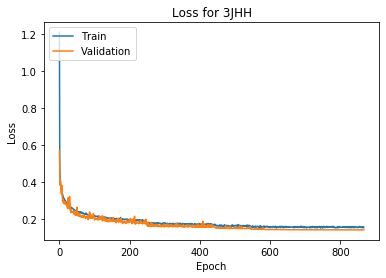

-1.944956146704153
Training 3JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1207321 samples, validate on 303058 samples
Epoch 1/2000
1207321/1207321 [==============================] - 12s 10us/step - loss: 0.9360 - val_loss: 0.7089
Epoch 2/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.6435 - val_loss: 0.6394
Epoch 3/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.5941 - val_loss: 0.5491
Epoch 4/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.5610 - val_loss: 0.5597
Epoch 5/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.5410 - val_loss: 0.5335
Epoch 6/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.5244 - val_loss: 0.5233
Epoch 7/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.5098 - val_loss: 0.5009
Epoch 8/2000
1207321/1207321 [==============================] - 11s 9

Epoch 73/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3621 - val_loss: 0.3613
Epoch 74/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3626 - val_loss: 0.3557
Epoch 75/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3616 - val_loss: 0.3560
Epoch 76/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3609 - val_loss: 0.3604
Epoch 77/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3609 - val_loss: 0.3558
Epoch 78/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3601 - val_loss: 0.3687
Epoch 79/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3604 - val_loss: 0.3515
Epoch 80/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3588 - val_loss: 0.3542
Epoch 81/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3575 - val_loss:

1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3250 - val_loss: 0.3308
Epoch 218/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3256 - val_loss: 0.3252
Epoch 219/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3245 - val_loss: 0.3311
Epoch 220/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3246 - val_loss: 0.3236
Epoch 221/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3236 - val_loss: 0.3251
Epoch 222/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3246 - val_loss: 0.3238
Epoch 223/2000
1207321/1207321 [==============================] - 11s 10us/step - loss: 0.3237 - val_loss: 0.3225
Epoch 224/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3237 - val_loss: 0.3262
Epoch 225/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3238 - val_loss: 0.32

1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3102 - val_loss: 0.3220
Epoch 362/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3101 - val_loss: 0.3133
Epoch 363/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3102 - val_loss: 0.3144
Epoch 364/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3114 - val_loss: 0.3225
Epoch 365/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3097 - val_loss: 0.3114
Epoch 366/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3108 - val_loss: 0.3140
Epoch 367/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3109 - val_loss: 0.3192
Epoch 368/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3104 - val_loss: 0.3190
Epoch 369/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.3110 - val_loss: 0.318

Epoch 505/2000
1207321/1207321 [==============================] - 11s 10us/step - loss: 0.2921 - val_loss: 0.2991
Epoch 506/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2933 - val_loss: 0.2987
Epoch 507/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2926 - val_loss: 0.3002
Epoch 508/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2930 - val_loss: 0.2980
Epoch 509/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2924 - val_loss: 0.3012
Epoch 510/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2922 - val_loss: 0.2989
Epoch 511/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2919 - val_loss: 0.3011
Epoch 512/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2926 - val_loss: 0.3028
Epoch 513/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2922 -

1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2894 - val_loss: 0.2984

Epoch 00649: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 650/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2845 - val_loss: 0.2901
Epoch 651/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2857 - val_loss: 0.2895
Epoch 652/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2841 - val_loss: 0.2909
Epoch 653/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2847 - val_loss: 0.2904
Epoch 654/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2834 - val_loss: 0.2904
Epoch 655/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2842 - val_loss: 0.2926
Epoch 656/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2838 - val_loss: 0.2891
Epoch 657/2000
1207321/1207321


Epoch 00720: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 721/2000
1207321/1207321 [==============================] - 11s 10us/step - loss: 0.2811 - val_loss: 0.2877
Epoch 722/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2811 - val_loss: 0.2871
Epoch 723/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2804 - val_loss: 0.2869
Epoch 724/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2801 - val_loss: 0.2877
Epoch 725/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2810 - val_loss: 0.2877
Epoch 726/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2801 - val_loss: 0.2870
Epoch 727/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2797 - val_loss: 0.2870
Epoch 728/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2809 - val_loss: 0.2866
Epoch 729/2000

Epoch 864/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2787 - val_loss: 0.2850
Epoch 865/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2777 - val_loss: 0.2850
Epoch 866/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2786 - val_loss: 0.2853
Epoch 867/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2779 - val_loss: 0.2856
Epoch 868/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2779 - val_loss: 0.2850
Epoch 869/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2778 - val_loss: 0.2851
Epoch 870/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2770 - val_loss: 0.2850
Epoch 871/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2769 - val_loss: 0.2849
Epoch 872/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2781 - 

1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2763 - val_loss: 0.2841
Epoch 936/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2764 - val_loss: 0.2841
Epoch 937/2000
1207321/1207321 [==============================] - 12s 10us/step - loss: 0.2767 - val_loss: 0.2843
Epoch 938/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2761 - val_loss: 0.2843
Epoch 939/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2768 - val_loss: 0.2844
Epoch 940/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2766 - val_loss: 0.2837
Epoch 941/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2751 - val_loss: 0.2840
Epoch 942/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2770 - val_loss: 0.2842
Epoch 943/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2769 - val_loss: 0.28

Epoch 1007/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2761 - val_loss: 0.2836
Epoch 1008/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2767 - val_loss: 0.2838
Epoch 1009/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2754 - val_loss: 0.2836
Epoch 1010/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2769 - val_loss: 0.2837
Epoch 1011/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2762 - val_loss: 0.2840
Epoch 1012/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2763 - val_loss: 0.2838
Epoch 1013/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2756 - val_loss: 0.2839
Epoch 1014/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 0.2761 - val_loss: 0.2837
Epoch 1015/2000
1207321/1207321 [==============================] - 11s 9us/step - loss: 

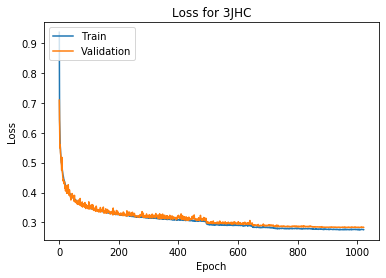

-1.2622940918525685
Training 3JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 133228 samples, validate on 33187 samples
Epoch 1/2000
133228/133228 [==============================] - 2s 14us/step - loss: 0.5960 - val_loss: 0.4455
Epoch 2/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.3711 - val_loss: 0.3818
Epoch 3/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.3253 - val_loss: 0.3051
Epoch 4/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.2952 - val_loss: 0.3004
Epoch 5/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.2782 - val_loss: 0.3089
Epoch 6/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.2622 - val_loss: 0.2725
Epoch 7/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.2489 - val_loss: 0.2667
Epoch 8/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.24

133228/133228 [==============================] - 1s 9us/step - loss: 0.1109 - val_loss: 0.1357
Epoch 149/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.1099 - val_loss: 0.1294
Epoch 150/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.1099 - val_loss: 0.1344
Epoch 151/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.1096 - val_loss: 0.1310
Epoch 152/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.1090 - val_loss: 0.1314
Epoch 153/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.1101 - val_loss: 0.1325
Epoch 154/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.1111 - val_loss: 0.1309
Epoch 155/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.1094 - val_loss: 0.1336
Epoch 156/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.1095 - val_loss: 0.1350
Epoch 157/2000
133228

133228/133228 [==============================] - 1s 10us/step - loss: 0.0952 - val_loss: 0.1211
Epoch 297/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0947 - val_loss: 0.1240

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 298/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0878 - val_loss: 0.1156
Epoch 299/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0866 - val_loss: 0.1152
Epoch 300/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0883 - val_loss: 0.1188
Epoch 301/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0850 - val_loss: 0.1158
Epoch 302/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0847 - val_loss: 0.1139
Epoch 303/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0893 - val_loss: 0.1135
Epoch 304/2000
133228/133228 [===================

133228/133228 [==============================] - 1s 9us/step - loss: 0.0746 - val_loss: 0.1094
Epoch 443/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0766 - val_loss: 0.1076
Epoch 444/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0762 - val_loss: 0.1104
Epoch 445/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0788 - val_loss: 0.1095
Epoch 446/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0771 - val_loss: 0.1090
Epoch 447/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0783 - val_loss: 0.1076
Epoch 448/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0767 - val_loss: 0.1105
Epoch 449/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0766 - val_loss: 0.1074
Epoch 450/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0780 - val_loss: 0.1072
Epoch 451/2000
1332

Epoch 588/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0723 - val_loss: 0.1042
Epoch 589/2000
133228/133228 [==============================] - 1s 10us/step - loss: 0.0733 - val_loss: 0.1041
Epoch 590/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0703 - val_loss: 0.1041
Epoch 591/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0717 - val_loss: 0.1042
Epoch 592/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0705 - val_loss: 0.1040
Epoch 593/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0726 - val_loss: 0.1044
Epoch 594/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0718 - val_loss: 0.1044
Epoch 595/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0733 - val_loss: 0.1040
Epoch 596/2000
133228/133228 [==============================] - 1s 9us/step - loss: 0.0708 - val_loss: 0.1044
Epoch 597

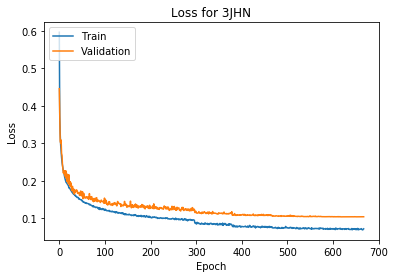

-2.2660278769624007


In [19]:
# Loop through each molecule type
for mol_type in mol_types:

    #model_name_wrt = ('/kaggle/working/molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')

    #X_train = X_train.fillna(0)
    #X_test = X_test.fillna(0)
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data = FeatureTransformer().transform(
        dataset=pd.concat([X_train, X_test]),
        ohe_features=oh_cols,
        continuous_features=continuous_cols
    )
    
    #target_data = target
    
    train = input_data[:len(X_train)]
    test_input = input_data[len(X_train):]
    
    cur_type_idx_train = (train_type == mol_type)
    cur_type_idx_test = (test_type == mol_type)

    cur_type_train = train[cur_type_idx_train]
    cur_type_target = target[cur_type_idx_train]
    cur_type_mols = molecule_name[cur_type_idx_train]

    train_idx, val_idx = next(GroupShuffleSplit(random_state=42, n_splits=1, test_size=0.2).split(cur_type_train, cur_type_target, cur_type_mols))

    x_train, y_train = cur_type_train[train_idx], cur_type_target[train_idx]
    x_val, y_val = cur_type_train[val_idx], cur_type_target[val_idx]


    # Build the Neural Net
    nn_model=create_nn_model(x_train.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    #sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(x_train, [y_train], 
            validation_data=(x_val, [y_val]), 
            callbacks=[es, rlr], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(x_val)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(y_val-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[test["type"]==mol_type]=test_predict[:,0][test["type"]==mol_type]
    K.clear_session()

cv_score_total/=len(mol_types)

In [23]:
import datetime
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
sub = feather.read_dataframe('../data/input/sample_submission.feather')
sub['scalar_coupling_constant'] = test_prediction
sub.to_csv('../data/nn_sub.csv', index=False)